# NLP, Scrapping avec Pocket - correction

Le notebook passe en revue plusieurs outils tels que [NLTK](http://www.nltk.org/), les [nuage de mots](https://fr.wikipedia.org/wiki/Nuage_de_mots-cl%C3%A9s), [expressions régulières](https://fr.wikipedia.org/wiki/Expression_r%C3%A9guli%C3%A8re) (correction).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Objectifs de la séance

- Compléter les données de l'API avec celles du webscraping
- Visualiser les données
- Nettoyer les données (regexp et nltk)
- Machine Learning "non-supervisé" : tagging automatique avec un tf-idf
- Amélioration de la prédiction de tags grâce à des méthodes de classifications binaires

## Compléter les données de l'API avec celles du webscraping

### Récupérer les données

Retrouver votre CONSUMER_KEY et votre ACCESS_TOKEN. Modifier les codes ci-dessous.

In [2]:
CONSUMER_KEY = "71268-0c68343bf8cd8c34e9029034"
ACCESS_TOKEN = "47d8c59a-c4f5-32be-f9f0-f3fabb"

On importe de nouveau les données du compte pocket.

In [3]:
import requests
from pprint import pprint

items = {
         "consumer_key":CONSUMER_KEY,
         "access_token":ACCESS_TOKEN,
         "detailsType": "complete"
        }

dict_pocket = requests.post('https://getpocket.com/v3/get', data = items).json()['list']

### En cas de probleme, vous pouvez importer les données à partir du .json

On va donc directement importer les données au format json.

In [4]:
import json
from pprint import pprint

with open('./data_pocket.json') as fp:    
    dict_pocket = json.load(fp)

for k, v in dict_pocket.items():
    print(k)
    pprint(v)
    break

{'1003565100': {'authors': {'55834601': {'author_id': '55834601',
                                         'item_id': '1003565100',
                                         'name': 'Grafikart.fr',
                                         'url': ''}},
                'excerpt': 'Ionic est un framework qui va vous permettre de '
                           'créer des applications mobiles en utilisant des '
                           'technologies Web. Ionic se base pour cela sur '
                           "d'autres frameworks / technologies qui ont fait "
                           'leurs preuves.  Avant de pouvoir commencer, il '
                           'nous faut évidemment commencer par installer '
                           "l'outil.",
                'favorite': '0',
                'given_title': 'Tutoriel Vidéo Apache Cordova Ionic Framework',
                'given_url': 'https://www.grafikart.fr/tutoriels/cordova/ionic-framework-641',
                'has_image': '0',
      

On créé une DataFrame avec les éléments souhaités (item_id, resolved_url, resolved_title, excerpt, tags).

### Mise en forme des données

In [5]:
dict_to_df = {}

keys = ['resolved_url', 'resolved_title', 'excerpt', 'tags']

for (k,v) in dict_pocket.items():
    dict_to_df[k] = dict(zip(keys, [v[key] for key in keys if key in v]))

In [6]:
import pandas as p
df_pocket = p.DataFrame.from_dict(dict_to_df, orient = "index")
df_pocket.head()

,resolved_title,resolved_url,excerpt,tags
1003565100,Tutoriel Vidéo Apache CordovaIonic Framework,https://www.grafikart.fr/tutoriels/cordova/ion...,Ionic est un framework qui va vous permettre d...,"{'mobile app': {'item_id': '1003565100', 'tag'..."
1008275819,Color Hunt,http://www.colorhunt.co,Home Create Likes () About Add To Chrome Faceb...,"{'lewagon': {'item_id': '1008275819', 'tag': '..."
1011618630,Out-of-Core Dataframes in Python: Dask and Ope...,https://jakevdp.github.io/blog/2015/08/14/out-...,"In recent months, a host of new tools and pack...","{'data science': {'item_id': '1011618630', 'ta..."
1014684096,A/B Testing with Hierarchical Models in Python,https://blog.dominodatalab.com/ab-testing-with...,"In this post, I discuss a method for A/B testi...","{'abtest': {'item_id': '1014684096', 'tag': 'a..."
1016233829,Getting started with the Web,https://developer.mozilla.org/en-US/docs/Learn...,Getting started with the Web is a concise seri...,"{'mdn': {'item_id': '1016233829', 'tag': 'mdn'..."


On met en forme la colonne "tags".

In [7]:
df_pocket['tags'] = df_pocket['tags'].apply(lambda x: list(x.keys()) if x==x else x)
df_pocket.rename(columns = {'resolved_url':'url', 'resolved_title': 'title'}, inplace = True)
df_pocket.head()

,title,url,excerpt,tags
1003565100,Tutoriel Vidéo Apache CordovaIonic Framework,https://www.grafikart.fr/tutoriels/cordova/ion...,Ionic est un framework qui va vous permettre d...,[mobile app]
1008275819,Color Hunt,http://www.colorhunt.co,Home Create Likes () About Add To Chrome Faceb...,[lewagon]
1011618630,Out-of-Core Dataframes in Python: Dask and Ope...,https://jakevdp.github.io/blog/2015/08/14/out-...,"In recent months, a host of new tools and pack...",[data science]
1014684096,A/B Testing with Hierarchical Models in Python,https://blog.dominodatalab.com/ab-testing-with...,"In this post, I discuss a method for A/B testi...",[abtest]
1016233829,Getting started with the Web,https://developer.mozilla.org/en-US/docs/Learn...,Getting started with the Web is a concise seri...,"[mdn, documentation]"


### Regular expression 

Par [ici](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_eco_5d_Travailler_du_texte_les_expressions_regulieres.html#td2aeco5dtravaillerdutextelesexpressionsregulieresrst).

Les expressions régulières (ou regular expression, regexp) servent à extraire des données de texte, ou à valider des données utilisateurs (lorsqu'un utilisateur rempli un formulaire par exemple). Voici les principaux caractères à connaître.

In [8]:
from ensae_teaching_cs.doc import regex_cases
regex_cases()

,Cas,Explications
0,-------,Bases
1,a,a
2,-------,Quantificateurs
3,abc?,ab suivi par 0 ou 1 c
4,abc*,ab suivi par 0.. c
5,abc+,ab suivi par 1.. c
6,abc{3},ab suivi par 3 c
7,"abc{3,5}","ab suivi par 3, 4 ou 5 c"
8,,Groupes
9,(abc)+,1..8 abc


Pour utiliser les regexp avec python, on fait appel au module "re", de la manière suivante : 

In [9]:
import re
string = "abc abccc abc ab bc"
print(re.compile("\w+").findall(string))

['abc', 'abccc', 'abc', 'ab', 'bc']


### Exercice 1

Extraire le domaine en utilisant des regexp. Le stocker dans un champs du DataFrame. Vous pouvez utiliser ce super outil : https://www.debuggex.com/

### Exercice 1 - correction

In [10]:
import re

def domain_extractor(url): 
    regex = re.compile("^((http|https)\:\/\/)?(www\.)?(.*)(\\.)((?!html|htm|php|asp|md|pdf)[a-z]{2,3})")
    try: 
        match_list = regex.findall(url)[0]
        return ''.join(match_list[-3:])
    except:
        return 'no_match'

In [11]:
df_pocket['domain']=df_pocket['url'].apply(lambda x: domain_extractor(x) )
df_pocket[['url','domain']].head()

,url,domain
1003565100,https://www.grafikart.fr/tutoriels/cordova/ion...,grafikart.fr
1008275819,http://www.colorhunt.co,colorhunt.co
1011618630,https://jakevdp.github.io/blog/2015/08/14/out-...,jakevdp.github.io
1014684096,https://blog.dominodatalab.com/ab-testing-with...,blog.dominodatalab.com
1016233829,https://developer.mozilla.org/en-US/docs/Learn...,developer.mozilla.org


### Ajout des données issues du webscraping

#### Contenu des pages présentes dans pocket

In [12]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import re

def words_htmltag(url):
    print(url)
    try: 
        html = requests.get(url).text
        soup = BeautifulSoup(html, 'lxml')
        words_dict = {}
        for html_tag in ['h1','h2','h3','p', 'article']:
            for e in soup.findAll(html_tag):
                text = e.get_text()
                words = re.split(r'\s+', text)
                # r'\s+' c est une expression reguliere.
                # celle-ci permet de splitter sur " ", "\t", "\n", "\r" meme s il y en a plusieurs d affilee
                words_dict[html_tag]=words 
        return words_dict
    except:
        return "scraper banned"

df_sample = df_pocket.ix[:2]

df_sample['html_soup'] = df_sample['url'].apply(lambda x: words_htmltag(x))

https://www.grafikart.fr/tutoriels/cordova/ionic-framework-641
http://www.colorhunt.co


/home/athean/anaconda3/envs/ensae/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
#df_sample.to_csv('./df_pocket.csv', index=False)

In [14]:
import pandas as p
import ast
df_pocket = p.read_csv('./df_pocket.csv')
df_pocket['html_soup'] = df_pocket['html_soup'].apply(lambda x : ast.literal_eval(x) if x != "scraper banned" else x)
df_pocket['tags'] = df_pocket['tags'].apply(lambda x : ast.literal_eval(x) if x == x else x)
df_pocket.head()

,tags,url,excerpt,title,domain,html_soup
0,[mobile app],https://www.grafikart.fr/tutoriels/cordova/ion...,Ionic est un framework qui va vous permettre d...,Tutoriel Vidéo Apache CordovaIonic Framework,grafikart.fr,"{'h2': ['Petit', 'tour', 'du', 'propriétaire']..."
1,[lewagon],http://www.colorhunt.co,Home Create Likes () About Add To Chrome Faceb...,Color Hunt,colorhunt.co,{}
2,[data science],https://jakevdp.github.io/blog/2015/08/14/out-...,"In recent months, a host of new tools and pack...",Out-of-Core Dataframes in Python: Dask and Ope...,jakevdp.github.io,"{'h2': ['Pubs', 'of', 'the', 'British', 'Isles..."
3,[abtest],https://blog.dominodatalab.com/ab-testing-with...,"In this post, I discuss a method for A/B testi...",A/B Testing with Hierarchical Models in Python,blog.dominodatalab.com,"{'h2': ['Recent', 'Posts'], 'h3': ['Related'],..."
4,"[mdn, documentation]",https://developer.mozilla.org/en-US/docs/Learn...,Getting started with the Web is a concise seri...,Getting started with the Web,developer.mozilla.org,"{'h2': ['Mozilla'], 'h3': ['How', 'the', 'web'..."


## Visualiser les données

Avant de sortir des statsitiques sur les termes que nous avons récupéré, il peut etre utile de les visualiser. Cela donne toujours des idées de voir les données. Pour cela on va utiliser la librairie [wordcloud](https://github.com/amueller/word_cloud).

In [15]:
! pip install wordcloud

You are using pip version 9.0.0, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [17]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
print(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white")

{'herself', 'she', 'then', "why's", 'cannot', 'k', "haven't", 'below', 'these', 'just', 'an', 'same', 'them', 'or', 'can', 'that', 'own', 'it', 'your', "you're", 'how', 'further', 'nor', 'in', 'could', "isn't", "we're", 'www', 'at', "aren't", 'ourselves', "they've", 'into', 'what', 'are', "here's", "i'd", 'on', 'hers', 'he', 'under', 'a', "who's", 'yourselves', "couldn't", 'any', 'where', 'had', 'again', "they'd", 'do', 'http', 'to', 'than', 'up', 'after', 'theirs', 'too', "wasn't", 'does', 'myself', 'if', 'has', 'doing', 'would', 'we', 'when', 'down', 'they', "weren't", "it's", 'so', 'were', "there's", 'only', 'yours', 'themselves', 'which', "they're", 'itself', 'being', 'shall', 'but', 'off', "how's", 'is', "that's", 'because', "he's", "she'll", 'ever', 'more', 'who', "i'm", 'against', 'while', "doesn't", "where's", 'the', 'our', 'her', "didn't", 'be', 'before', "he'll", 'above', 'about', 'with', 'did', 'been', "don't", "shouldn't", 'from', 'most', "i've", "wouldn't", 'by', 'having',

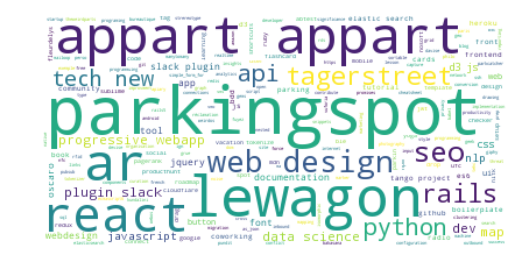

In [18]:
tags_string = ' '.join(df_pocket['tags'].apply(lambda x: ' '.join(x) if x==x else ''))
wordcloud.generate(tags_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Exercice 2

### Exercice 2 - 1

Pour les webmasters qui cherchent à optimiser le référencement de leur site dans le moteur de recherche Google, il est important d'avoir une cohérence des termes utilisés dans les titles, balises h1 et urls. Faire des wordcloud sur ces champs et voir si c'est respecté ici.

### Exercice 2 - 2

Analyser les termes présents dans les champs h2, h3, et p de html_soup et, dans l'excerpt. A votre avis, faudra-t-il donner le même poids aux mots contenus dans ces champs qu'à ceux contenus dans les h1, title et urls ? Si certains mots fréquents vous surprennent, il peut s'agir d'un biais dans les sites bookmarqués : n'hésitez pas à lister les urls correspondantes !

### Exercice 2 - 3

En se restreignant aux urls qui ont des tags, comparer les nuages des mots contenus dans les champs h1, title et urls avec les tags. Qu'en déduisez-vous ?

Astuce:  Penser à étoffer les stopwords en fonction des résultats (par exemple, il y a beaucoup "de", "le", "la" (l'objet STOPWORDS proposé dans wordcloud est en anglais).

### Exercice 2 - correction

Stopwords améliorés:

In [19]:
for wds in ['http', 'https', 'www', 'fr', 'com', 'io', 'org', 'co', 'jo', 'edu', 'news', 'html', 'htm',\
            'github', 'youtube', 'google', 'blog', 'watch', 'de', 'le', 'la', 'en', 'sur', 'vous', 'les', \
           'ajouter', 'README', 'md', 'et', 'PROCESS', 'CMYK', 'des', 'chargement', 'playlists', 'endobj', \
           'obj','est', 'use', 'using', 'will', 'web', 'first','pour', 'du', 'une', 'que']:
    stopwords.add(wds)

### Exercice 2 - 1 - correction

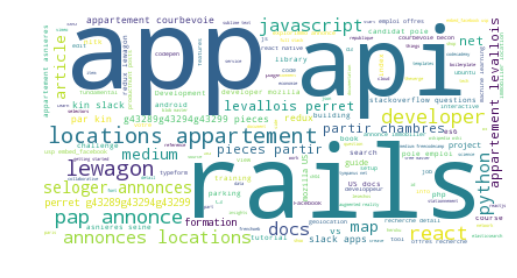

In [20]:
def url_cleaning(url):
    return ' '.join(re.split(r'\/|\.|\:|-|\?',url))

url_string = ' '.join(df_pocket['url'].apply(lambda x : url_cleaning(x)))
wordcloud.generate(url_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

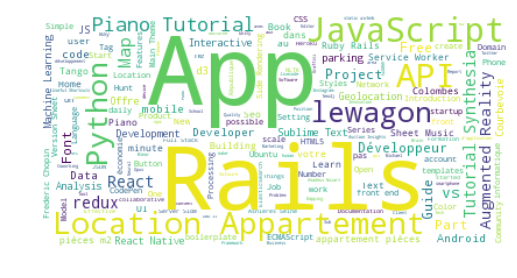

In [21]:
def nan_to_string(x):
    if x==x:
        return x
    else:
        return ''

title_string = ' '.join(df_pocket['title'].apply( lambda x: nan_to_string(x)))
wordcloud.generate(title_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

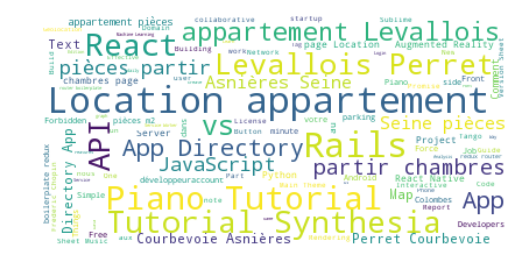

In [22]:
def hx_cleaning(d,hx):
    if str(hx) in d:
        return ' '.join(d[str(hx)])
    else: 
        return ''
     
h1_string = ' '.join(df_pocket['html_soup'].apply(lambda x : hx_cleaning(x,'h1')))
wordcloud.generate(h1_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [23]:
df_pocket['h1'] = df_pocket['html_soup'].apply(lambda x : ' '.join(x['h1']) if 'h1' in x else '')
df_pocket['domain'][df_pocket['h1'].str.contains('Tutorial')]

8               youtube.com
47              youtube.com
51              youtube.com
60              youtube.com
63              youtube.com
119             youtube.com
121             youtube.com
185             youtube.com
353             youtube.com
415             youtube.com
430             youtube.com
442             youtube.com
450             youtube.com
466    ccoenraets.github.io
Name: domain, dtype: object

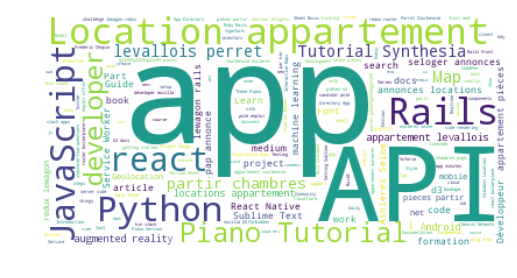

In [24]:
seo_string = ' '.join([url_string, title_string, h1_string])
wordcloud.generate(seo_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Conclusion: les title et les urls sont cohérentes. Meilleure structure des balises h1 pour les sites de logement => écrase visuellement les h1 des autres sites.

### Exercice 2 - 2 - correction

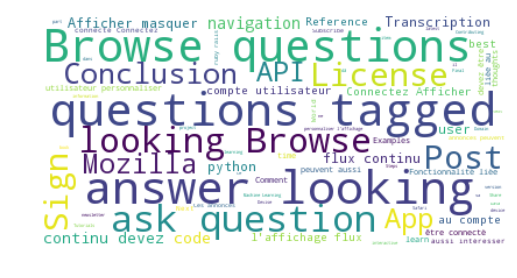

In [25]:
h2_string = ' '.join(df_pocket['html_soup'].apply(lambda x : hx_cleaning(x,'h2')))
wordcloud.generate(h2_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [26]:
df_pocket['h2'] = df_pocket['html_soup'].apply(lambda x : ' '.join(x['h2']) if 'h2' in x else '')
df_pocket['domain'][df_pocket['h2'].str.contains('Browse')]

73                stackoverflow.com
92                    askubuntu.com
174               stackoverflow.com
226               stackoverflow.com
357               stackoverflow.com
360               stackoverflow.com
363           visionmedia.github.io
416               stackoverflow.com
461    webmasters.stackexchange.com
Name: domain, dtype: object

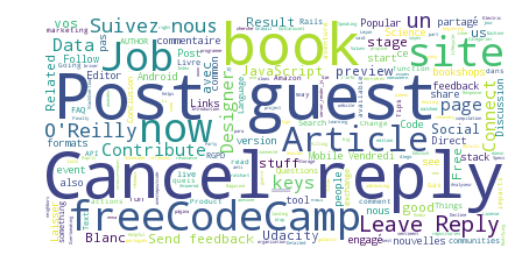

In [27]:
h3_string = ' '.join(df_pocket['html_soup'].apply(lambda x : hx_cleaning(x, 'h3')))
wordcloud.generate(h3_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [28]:
df_pocket['h3'] = df_pocket['html_soup'].apply(lambda x : ' '.join(x['h3']) if 'h3' in x else '')
df_pocket['domain'][df_pocket['h3'].str.contains('Cancel')]

149           mathiasp.fr
229           zuehlke.com
245         kevinbinz.com
255      marketoonist.com
405            mlwave.com
460    marcobonzanini.com
Name: domain, dtype: object

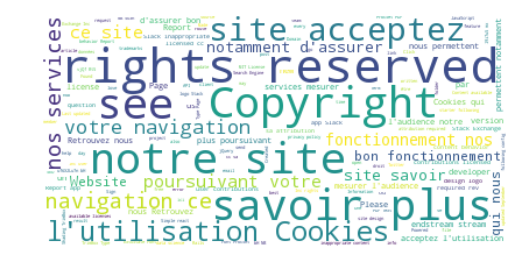

In [29]:
def p_cleaning(x):
    if (type(x) == dict) & ('p' in x ):
        return ' '.join(x['p'])
    else: 
        return ''

p_string = ' '.join(df_pocket['html_soup'].apply(lambda x : p_cleaning(x)))
wordcloud.generate(p_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [30]:
df_pocket['p'] = df_pocket['html_soup'].apply(lambda x : ' '.join(x['p']) if (type(x) == dict) & ('p' in x ) else '')
sorted(df_pocket['domain'][df_pocket['p'].str.contains('web')])

['code.tutsplus.com',
 'flexbox.io',
 'fontsquirrel.com',
 'fontsquirrel.com',
 'frenchweb.fr',
 'frenchweb.fr',
 'frenchweb.job',
 'github.com',
 'github.com',
 'market.mashape.com',
 'medium.com',
 'paybyphone.com',
 'producthunt.com',
 'redis.io',
 'statstool.com',
 'statstool.com']

Conclusion: h2, h3, et p : champ sémantique très éloigné des urls, title et balises h1. Cela provient d'un biais dans les sites bookmarqués (les sites stackoverflow par exemple, sont caractérisés par le fait d'indiquer le mot "Browse" dans une balise h2). Par ailleurs, ces balises ne semblent pas attirer de mots qui pourraient faire l'objet d'un tag automatique. Mieux vaut se concentrer sur les title et url.

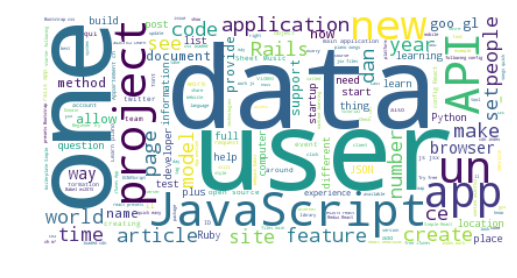

In [31]:
excerpt_string = ' '.join(df_pocket['excerpt'].apply( lambda x: nan_to_string(x)))
wordcloud.generate(excerpt_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Mots génériques. Un tf-idf va nous aider à faire ressortir les mots spécifiques.

### Exercice 2 - 3 - correction

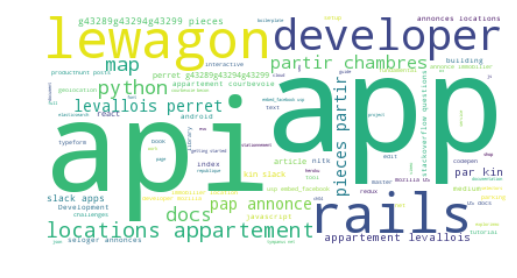

In [32]:
url_string_iftags = ' '.join(df_pocket['url'][df_pocket['tags'] == df_pocket['tags']].apply(lambda x : ' '.join(re.split(r'\/|\.|\:|-|\?',x))))
wordcloud.generate(url_string_iftags)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

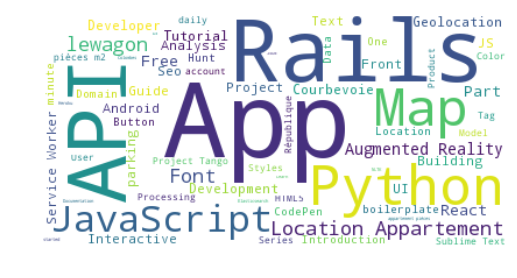

In [33]:
title_string_iftags = ' '.join(df_pocket['title'][df_pocket['tags'] == df_pocket['tags']].apply( lambda x: x if x==x else ''))
wordcloud.generate(title_string_iftags)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

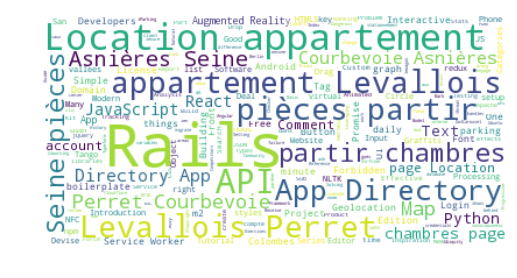

In [34]:
h1_string_iftags = ' '.join(df_pocket['html_soup'][df_pocket['tags'] == df_pocket['tags']].apply(lambda x : ' '.join(x['h1'] if 'h1' in x else '')))
wordcloud.generate(h1_string_iftags)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

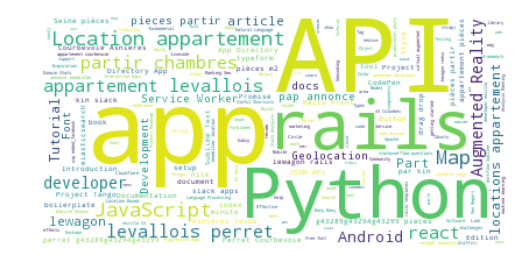

In [35]:
seo_string_iftags = ' '.join([url_string_iftags, title_string_iftags, h1_string_iftags])
wordcloud.generate(seo_string_iftags)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

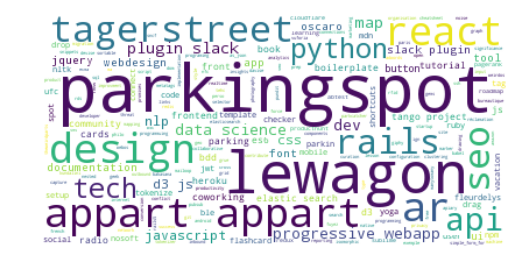

In [36]:
tags_string = ' '.join(df_pocket['tags'].apply(lambda x: ' '.join(x) if x==x else ''))
wordcloud.generate(tags_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Conclusion : il y a des spécificités dans la manière de tagger. Pour le dire autrement, il y a de fortes chances pour que ces contenus ne soient pas faciles à trouver dans google avec les mots-clés indiqués dans tags :) Soit parce que c'est "mal taggé", soit parce c'est "mal ranké" par Google, soit (hypothèse la plus plausible) : parce qu'il y a un biais dans l'utilisation de l'application pocket : on ne bookmarque que ce qu'il est difficile de trouver dans le web => nécessité d'un classificateur personnalisé.

## Nettoyer les données (regexp et nltk)

Mais avant tout, nous devrions augmenter la qualité de nos données (en améliorant les parsers et la liste des stopwords). C'est l'objet de cette section.

In [37]:
words = ' '.join([title_string,url_string,h1_string,h2_string,h3_string,excerpt_string])
# on ne conserve que les mots
words_string = re.sub('[^A-Za-z ]','', words)
#on "nettoie les espaces"
words_string = re.sub('\s+',' ', words_string)
words_string[:1000]

'Tutoriel Vido Apache CordovaIonic Framework Color Hunt OutofCore Dataframes in Python Dask and OpenStreetMap AB Testing with Hierarchical Models in Python Getting started with the Web Le Wagon UI components shakacodereactonrails Le Wagon Alumni Nocturne Opus No Frederic Chopin Piano Tutorial Synthesia ES Promises in Depth Jupyter Notebook Viewer Introduction lanalyse de texte avec nltk Tokenization CamFind API Documentation Build an Elasticsearch Index with PythonMachine Learning Series Part The MustHave Discovery Tool for every Media Professional Python NLTK WTF Chapter Notes'

In [38]:
! pip install nltk

You are using pip version 9.0.0, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Nltk contient un corpus de stopwords en plusieurs langues. On peut enrichir la liste déjà créée.

In [39]:
import nltk
stopwords_fr_ntlk = set(nltk.corpus.stopwords.words('french'))
stopwords_en_ntlk = set(nltk.corpus.stopwords.words('english'))
stopwords_clean = [l.lower() for l in list(stopwords.union(stopwords_fr_ntlk).union(stopwords_en_ntlk))]
stopwords_clean[:20]

['herself',
 'she',
 "why's",
 'org',
 'k',
 'sur',
 'just',
 'same',
 'or',
 'that',
 'it',
 'your',
 'use',
 'ayantes',
 'soyez',
 "you're",
 'further',
 'in',
 'github',
 'could',
 "isn't",
 "we're",
 'fûmes',
 'ourselves',
 "they've",
 'until']

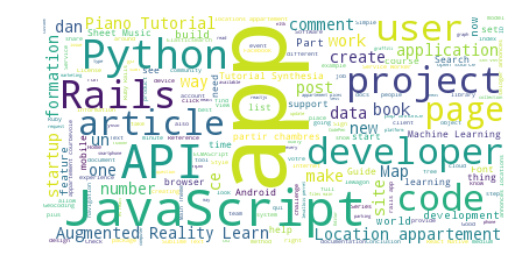

In [40]:
wordcloud.generate(words_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

On applique tout ça à df_pocket.

In [41]:
def words_cleaning(url,title,excerpt,html_soup):
    url_clean = url_cleaning(url)
    title_clean = nan_to_string(title)
    excerpt_clean = nan_to_string(excerpt)
    h1_clean = hx_cleaning(html_soup,'h1')
    h2_clean = hx_cleaning(html_soup,'h2')
    h3_clean = hx_cleaning(html_soup,'h3')
    p_clean = p_cleaning(html_soup)
    words = ' '.join([url_clean, title_clean, excerpt_clean, h1_clean, h2_clean, h3_clean, p_clean])
    words_clean = re.sub('[^A-Za-z ]','', words)
    words_clean = re.sub('\s+',' ', words_clean)
    words_list = words_clean.split(' ')
    return ' '.join([w.lower() for w in words_list if w not in stopwords_clean])

In [42]:
df_pocket['words_string'] = np.vectorize(words_cleaning)(df_pocket['url'], \
                                                         df_pocket['title'], \
                                                         df_pocket['excerpt'], \
                                                         df_pocket['html_soup'])
df_pocket.head()

,tags,url,excerpt,title,domain,html_soup,h1,h2,h3,p,words_string
0,[mobile app],https://www.grafikart.fr/tutoriels/cordova/ion...,Ionic est un framework qui va vous permettre d...,Tutoriel Vidéo Apache CordovaIonic Framework,grafikart.fr,"{'h2': ['Petit', 'tour', 'du', 'propriétaire']...",Tutoriel Vidéo Apache CordovaIonic Framework ...,Petit tour du propriétaire,La compilation,,grafikart tutoriels cordova ionic framework tu...
1,[lewagon],http://www.colorhunt.co,Home Create Likes () About Add To Chrome Faceb...,Color Hunt,colorhunt.co,{},,,,,colorhunt color hunt home create likes about a...
2,[data science],https://jakevdp.github.io/blog/2015/08/14/out-...,"In recent months, a host of new tools and pack...",Out-of-Core Dataframes in Python: Dask and Ope...,jakevdp.github.io,"{'h2': ['Pubs', 'of', 'the', 'British', 'Isles...",Comments,Pubs of the British Isles¶,Dask Arrays¶,This post was written entirely in the IPython ...,jakevdp core dataframes python outofcore dataf...
3,[abtest],https://blog.dominodatalab.com/ab-testing-with...,"In this post, I discuss a method for A/B testi...",A/B Testing with Hierarchical Models in Python,blog.dominodatalab.com,"{'h2': ['Recent', 'Posts'], 'h3': ['Related'],...",Conclusion,Recent Posts,Related,Get Data Science Updates,dominodatalab ab testing hierarchical models p...
4,"[mdn, documentation]",https://developer.mozilla.org/en-US/docs/Learn...,Getting started with the Web is a concise seri...,Getting started with the Web,developer.mozilla.org,"{'h2': ['Mozilla'], 'h3': ['How', 'the', 'web'...",Getting started with the Web,Mozilla,How the web works,Content is available under these licenses.,developer mozilla us docs learn gettingstarted...


## Natural Language Processing et tf-idf

Lire [introduction au NLP](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#td2atd5traitementautomatiquedeslanguesenpythonrst)

### Exercice 3

S'inspirer de [introduction à nltk](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#introduction-a-nltk) et analyser les principaux termes de recherche des documents.

### Exercice 3 - correction

In [43]:
import re, nltk
#Tokenisation naïve sur les espaces entre les mots => on obtient une liste de mots
tokens = re.split('\s+', ' '.join(df_pocket['words_string']))

#On transforme cette liste en objet nltk "Text" (objet chaine de caractère qui conserve la notion de tokens, et qui 
#comprend  un certain nombre de méthodes utiles pour explorer les données.
text = nltk.Text(tokens)

#Comme par exemple "concordance" : montre les occurences d'un mot dans son contexte
print("Exemples d'occurences du terme 'python' :")
text.concordance("python")
print('\n')

# Analyse de la fréquence des termes d'intérêt 
fdist = text.vocab()
print("Co-occurences fréquentes :")
text.collocations()
print('\n')

print("Nombre de mots :", len(tokens))
print('\n')
print("Nombre de mots uniques :",len(fdist.keys()))
print('\n')
print("Nombre d'occurences du terme 'github' :",fdist["github"])
print("Nombre d'occurences du terme 'python' :",fdist["python"])
print("Nombre d'occurences du terme 'javascript' :",fdist["javascript"])
print("Nombre d'occurences du terme 'rails' :",fdist["rails"])
print("Nombre d'occurences du terme 'data' :", fdist["source"])
print("Nombre d'occurences du terme 'web' :", fdist["web"])
print("Nombre d'occurences du terme 'API' :",fdist["API"])
print('\n')

#10 tokens les plus fréquents
top100_items = sorted(fdist.items(),key=lambda x: x[1],reverse=True)[:100]
#sans les fréquences
top100 = [t[0] for t in top100_items]
print("Top 100 :", top100)
print('\n')

#sans les termes trop frequents ("stopwords")
top100_without_stopwords = [w for w in top100 if w.lower() \
                         not in stopwords_clean]
print("Top 100 sans les mots fréquents :", top100_without_stopwords)
print('\n')

# Enumerate the frequency distribution
for rank, word in enumerate(sorted(fdist.items(),key=lambda x: x[1],reverse=True)):
    if word[0].lower() not in stopwords_clean:
        print(rank, word)
        if rank > 75:
            print("....")
            break

Exemples d'occurences du terme 'python' :
Displaying 25 of 52 matches:
wed hunters jakevdp core dataframes python outofcore dataframes python dask op
aframes python outofcore dataframes python dask openstreetmap in recent months
ckages announced working data scale python for excellent entertaining summary 
mary id suggest watching rob storys python data bikeshed talk pydata seattle c
alab ab testing hierarchical models python ab testing hierarchical models pyth
thon ab testing hierarchical models python in post i discuss method ab testing
te nltk tokenization nltk librairie python trs utile manipuler texte market ma
s qbox building elasticsearch index python build elasticsearch index pythonmac
volving world media mikesboyle post python nltk wtf chapter notes things pytho
ython nltk wtf chapter notes things python nltk wtf chapter notes things dont 
orpus linguistics fan learning code python excellent online tutorial called na
 called natural language processing python also book buy cas

### Exercice 4

S'inspirer de [tf-idf à la main](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#analyse-des-donnees-textuelles-td-idf-similarite-cosine-et-n-grams) ou de [tf-idf avec nltk](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#requeter-les-donnees-google-avec-tf-idf) et faire un moteur de recherche. Trouver les 5 documents les plus pertinents pour les mots-clés ['python','data', 'science']. Quels avantages a votre moteur de recherche par rapport à celui proposé par pocket ?

### Exercice 4 - correction

Un moteur de recherche pour ['python','data','science'].

In [44]:
QUERY_TERMS = ['python','data','science']

# Le package TextCollection contient un module tf-idf
items = list(df_pocket['words_string'].apply(lambda x: re.split('\s+',x)))
tc = nltk.TextCollection(items)

relevant_items = []

for idx in range(len(items)):
    score = 0
    for term in [t.lower() for t in QUERY_TERMS]:
        score += tc.tf_idf(term, items[idx])
    if score > 0:
        relevant_items.append({'score': score, 'title': df_pocket.ix[idx]['title'],
                              'url': df_pocket.ix[idx]['url']})

# Tri par score et présentation des résultats 

relevant_items = sorted(relevant_items, 
                             key=lambda p: p['score'], reverse=True)
c=0
for item in relevant_items:
    if c < 6:
        print(item['title'])
        print('\tLink: {}'.format(item['url']))
        print('\tScore: {}'.format(item['score']))
        c+=1

Data Science Summer School 2017
	Link: https://portail.polytechnique.edu/datascience/en/data-science-summer-school-2017
	Score: 0.8709055939765689
Python Programming Tutorials
	Link: https://pythonprogramming.net/
	Score: 0.5455958117188691
A/B Testing with Hierarchical Models in Python
	Link: https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/
	Score: 0.3566480268022002
nan
	Link: http://www.nltk.org/book/ch04.html
	Score: 0.3269558242866164
Mining Twitter Data with Python (and JS) – Part 7: Geolocation and Interactive Maps
	Link: https://marcobonzanini.com/2015/06/16/mining-twitter-data-with-python-and-js-part-7-geolocation-and-interactive-maps/
	Score: 0.32171928868718935
Out-of-Core Dataframes in Python: Dask and OpenStreetMap
	Link: https://jakevdp.github.io/blog/2015/08/14/out-of-core-dataframes-in-python/
	Score: 0.31775098311043803


## Catégorisation automatique avec une méthode de machine learning non-supervisé : LDA

### Exercice 5

S'inspirer de [LDA](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/) et [un exemple de LDA](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_some_nlp.html#lda) et proposer une catégorisation automatique des documents. Comparer aux tags initiaux.

### Exercice 5 - correction

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(df_pocket['words_string'])

In [46]:
tfidf.shape

(469, 1000)

In [47]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=30, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [48]:
lda.fit(tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_jobs=1, n_topics=30, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [49]:
tf_feature_names = tfidf_vectorizer.get_feature_names()
tf_feature_names

['ab',
 'about',
 'acceptez',
 'access',
 'accord',
 'account',
 'action',
 'active',
 'add',
 'adding',
 'address',
 'adwords',
 'ajouter',
 'algorithm',
 'all',
 'allows',
 'along',
 'already',
 'also',
 'amazon',
 'analysis',
 'and',
 'android',
 'animated',
 'annonce',
 'annonces',
 'answer',
 'any',
 'apache',
 'api',
 'apis',
 'app',
 'youve',
 'zimmer']

In [50]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [51]:
print_top_words(lda, tf_feature_names, 3)

Topic #0:
ui inspiration geocoding
Topic #1:
screen man project
Topic #2:
jeu clef effective
Topic #3:
internet partage parle
Topic #4:
appartement courbevoie seloger
Topic #5:
obd geocoding test
Topic #6:
seo android components
Topic #7:
jobs product supplier
Topic #8:
data path the
Topic #9:
millions numbers javascript
Topic #10:
piano synthesia tutorial
Topic #11:
project tango augmented
Topic #12:
fonts adwords auction
Topic #13:
make statistical va
Topic #14:
formation font emploi
Topic #15:
app slack machine
Topic #16:
open recognition download
Topic #17:
array top mozilla
Topic #18:
css codepen net
Topic #19:
server coworking objects
Topic #20:
events cloudflare event
Topic #21:
document interne makes
Topic #22:
react google simple
Topic #23:
beautiful vs learn
Topic #24:
sublime text shortcuts
Topic #25:
site en cookies
Topic #26:
le neoj la
Topic #27:
javascript rails python
Topic #28:
geolocation api chapter
Topic #29:
api rails json

